# Recovery of Random Effects

Given model parameters, we can now back out the implied market-time and station-level "random" effects. To be clear, these are really just like fixed effects, with the imposed assumptions that:
1. The sum total of the effects is normally distributed, and
2. Effects are uncorrelated with disturbances.

I think of 2 as really the important part of the Random Effects paradigm. Anyways, we first set up our `ipython` session and get our directories pointed in the right direction:

In [1]:
import ipystata
import os
os.getcwd()

'C:\\Users\\mjbaker\\Documents\\GitHub\\NewsHour'

In [2]:
%%stata -s nh1
cd C:\Users\mjbaker\Documents\GitHub\NewsHour
clear all
use AveragedDataDyno.dta


C:\Users\mjbaker\Documents\GitHub\NewsHour


Next, we can read in all of our data and results (which are actually old - we need to reestimate things and save, remember!)

In [3]:
%%stata -s nh1
mata:
    st_view(dln=.,.,"dln")
    st_view(ln_swg=.,.,"ln_swg")
    st_view(lnews=.,.,"lnews")
    st_view(otherl=.,.,"otherl")
    st_view(nnews=.,.,"nnews")
    st_view(otherc=.,.,"otherc")
    st_view(ma=.,.,"market")
    st_view(id=.,.,"stationid")
    st_view(mt=.,.,"mt")
    st_view(lnewslnews=.,.,"lnewslnews")
    st_view(lnewsnnews=.,.,"nnewsnnews")
    st_view(nnewslnews=.,.,"nnewslnews")
    st_view(nnewsnnews=.,.,"nnewsnnews")
    st_view(siXlnln=.,.,"siXlnln")
    st_view(siXlnnn=.,.,"siXlnnn")
    st_view(siXnnln=.,.,"siXnnln")
    st_view(siXnnnn=.,.,"siXnnnn")
    st_view(lnewstot=.,.,"lnewstot")
    st_view(nnewstot=.,.,"nnewstot")
    st_view(lsi=.,.,"lsi")	
    st_view(l_ACS_HH=.,.,"l_ACS_HH")
    
    st_view(lnewsn=.,.,"lnewsn")
    st_view(nnewsn=.,.,"nnewsn")
    st_view(otherln=.,.,"otherln")
    st_view(othercn=.,.,"othercn")
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     st_view(dln=.,.,"dln")

:     st_view(ln_swg=.,.,"ln_swg")

:     st_view(lnews=.,.,"lnews")

:     st_view(otherl=.,.,"otherl")

:     st_view(nnews=.,.,"nnews")

:     st_view(otherc=.,.,"otherc")

:     st_view(ma=.,.,"market")

:     st_view(id=.,.,"stationid")

:     st_view(mt=.,.,"mt")

:     st_view(lnewslnews=.,.,"lnewslnews")

:     st_view(lnewsnnews=.,.,"nnewsnnews")

:     st_view(nnewslnews=.,.,"nnewslnews")

:     st_view(nnewsnnews=.,.,"nnewsnnews")

:     st_view(siXlnln=.,.,"siXlnln")

:     st_view(siXlnnn=.,.,"siXlnnn")

:     st_view(siXnnln=.,.,"siXnnln")

:     st_view(siXnnnn=.,.,"siXnnnn")

:     st_view(lnewstot=.,.,"lnewstot")

:     st_view(nnewstot=.,.,"nnewstot")

:     st_view(lsi=.,.,"lsi")

:     st_view(l_ACS_HH=.,.,"l_ACS_HH")

:     
:     st_view(lnewsn=.,.,"lnewsn")

:     st_view(nnewsn=.,.,"nnewsn")

:     st_view(o

Pull in all the results. Note that one thing we can append in the results-analyze component of the paper is an extended analysis of the results. Since the results are draws from the parameter distribution implied by the likelihood function, we take the mean as the mean parameter value (remembering that we have to transform some of the parameters). 

Anyways, here goes:

In [4]:
%%stata -s nh1
mata:
    mata matuse Results, replace
    b_start[,1::4]=b_start[,1::4]:^2
    bo=mean(b_start)
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     mata matuse Results, replace
(loading b_start[400,37])

:     b_start[,1::4]=b_start[,1::4]:^2

:     bo=mean(b_start)

: end


Next we can set up the data, and rearrange some of the parameters (note to self - include a schematic for the parameters)

In [5]:
%%stata -s nh1
mata:
    Xv=ln_swg:*lnews,ln_swg:*otherl,ln_swg:*nnews,ln_swg:*otherc,
        lnews,otherl,nnews,
        lnewslnews,lnewsnnews,nnewslnews,nnewsnnews,lsi,
        siXlnln,siXlnnn,siXnnln,siXnnnn,lnews:*ln(1:+lnewstot),nnews:*ln(1:+nnewstot),l_ACS_HH,
        lnewsn,otherln,nnewsn,othercn,J(rows(lnews),1,1)

    b=bo[(1..23,27)]
    sdmodDy=exp(bo[26])
    sdstaDy=exp(bo[24])
    sdmarDy=exp(bo[25])
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     Xv=ln_swg:*lnews,ln_swg:*otherl,ln_swg:*nnews,ln_swg:*otherc,
>         lnews,otherl,nnews,
>         lnewslnews,lnewsnnews,nnewslnews,nnewsnnews,lsi,
>         siXlnln,siXlnnn,siXnnln,siXnnnn,lnews:*ln(1:+lnewstot),nnews:*ln(1:+nnewstot),l_ACS_HH,
>         lnewsn,otherln,nnewsn,othercn,J(rows(lnews),1,1)

:     sdmodDy=exp(bo[26])

:     sdstaDy=exp(bo[24])

:     sdmarDy=exp(bo[25])

: end


Now, we need a routine that recovers our implied fixed effects given parameters. Here is a mata routine that does this. Since we only need this at this particular point in the paper, we don't bother writing it as a specialized `Mata` function. Also, note that data must be sorted by market-time, and then by id for this to work correctly!

In [6]:
%%stata -s nh1
mata:
    real matrix indEffect3(real matrix mar, real matrix mt,real matrix id,
        real matrix ymXBhat, real scalar sdmod,
        real scalar sdsta, real scalar sdmar)
    {

    real scalar i,T
    real matrix mtp,idp,Zs,Zm,ymXBhatp,Vu,VuInv

    m=panelsetup(mar,1)

    alphaS=J(rows(mt),1,.)
    alphaM=J(rows(mt),1,.)

    for (i=1;i<=rows(m);i++) {
        mtp=panelsubmatrix(mt,i,m)
        idp=panelsubmatrix(id,i,m)
        T=rows(uniqrows(mtp))
        N=rows(uniqrows(idp))
        ymXBhatp=panelsubmatrix(ymXBhat,i,m)
    
        Zs=I(N)#J(T,1,1)
        Zm=J(N,1,1)#I(T)
    
        Vu=I(N*T)+sdsta^2/sdmod^2*Zs*Zs'+sdmar^2/sdmod^2*Zm*Zm'
        VuInv=invsym(Vu)
        
        alphaS[m[i,1]::m[i,2],1]=(sdsta^2/sdmod^2*Zs'VuInv*ymXBhatp)#J(T,1,1)
        alphaM[m[i,1]::m[i,2],1]=J(N,1,1)#(sdmar^2/sdmod^2*Zm'VuInv*ymXBhatp)	
    }

    return((alphaS,alphaM))
    }
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     real matrix indEffect3(real matrix mar, real matrix mt,real matrix id,
>         real matrix ymXBhat, real scalar sdmod,
>         real scalar sdsta, real scalar sdmar)
>     {
> 
>     real scalar i,T
>     real matrix mtp,idp,Zs,Zm,ymXBhatp,Vu,VuInv
> 
>     m=panelsetup(mar,1)
> 
>     alphaS=J(rows(mt),1,.)
>     alphaM=J(rows(mt),1,.)
> 
>     for (i=1;i<=rows(m);i++) {
>         mtp=panelsubmatrix(mt,i,m)
>         idp=panelsubmatrix(id,i,m)
>         T=rows(uniqrows(mtp))
>         N=rows(uniqrows(idp))
>         ymXBhatp=panelsubmatrix(ymXBhat,i,m)
>     
>         Zs=I(N)#J(T,1,1)
>         Zm=J(N,1,1)#I(T)
>     
>         Vu=I(N*T)+sdsta^2/sdmod^2*Zs*Zs'+sdmar^2/sdmod^2*Zm*Zm'
>         VuInv=invsym(Vu)
>         
>         alphaS[m[i,1]::m[i,2],1]=(sdsta^2/sdmod^2*Zs'VuInv*ymXBhatp)#J(T,1,1)
>         alphaM[m[i,1]::m[i,2],1]=J(N,1,1)#(sdmar^2

Effects for the viewership model...

In [7]:
%%stata -s nh1
mata:
    IEv=indEffect3(ma,mt,id,dln:-Xv*b', sdmodDy,sdstaDy,sdmarDy)
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     IEv=indEffect3(ma,mt,id,dln:-Xv*b', sdmodDy,sdstaDy,sdmarDy)

: end


Now, we can do the effects for the price model. First, let's read in variables and mark them with a `price` variable so we know which ones we are actually using. Accordingly:

In [8]:
%%stata -s nh1
gen price = lnpps != .

We also need a total viewership variable, and for purposes of merging `mata` variables back into the `Stata` data set, we create an `obsid` variable so we can remember which variables are used...

In [9]:
%%stata -s nh1
gen lnview = ln(si*ACS_HH)
gen obsid = _n

Read in all the pricing variables to be used:

In [10]:
%%stata -s nh1
mata:
    st_view(lnpps=.,.,"lnpps","price")
    st_view(lnewsp=.,.,"lnews","price")
    st_view(nnewsp=.,.,"nnews","price")
    st_view(otherlp=.,.,"otherl","price")
    st_view(lnview=.,.,"lnview","price")
    st_view(map=.,.,"market","price")
    st_view(mtp=.,.,"mt","price")
    st_view(idp=.,.,"stationid","price")
    st_view(obsid=.,.,"obsid","price")
    st_view(l_ACS_HHp=.,.,"l_ACS_HH","price")
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     st_view(lnpps=.,.,"lnpps","price")

:     st_view(lnewsp=.,.,"lnews","price")

:     st_view(nnewsp=.,.,"nnews","price")

:     st_view(otherlp=.,.,"otherl","price")

:     st_view(lnview=.,.,"lnview","price")

:     st_view(map=.,.,"market","price")

:     st_view(mtp=.,.,"mt","price")

:     st_view(idp=.,.,"stationid","price")

:     st_view(obsid=.,.,"obsid","price")

:     st_view(l_ACS_HHp=.,.,"l_ACS_HH","price")

: end


Now, we can slap all the variables into matrix form, and transform and rearrange parameters as required:

In [11]:
%%stata -s nh1
mata: 
    Xp=lnewsp:*lnview,otherlp:*lnview,nnewsp:*lnview,lnewsp,otherlp,l_ACS_HHp,J(rows(lnewsp),1,1)
    
    bp=bo[(28..33,37)]
    sdstap=exp(bo[34])
    sdmarp=exp(bo[35])
    sdmodp=exp(bo[36])
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     Xp=lnewsp:*lnview,otherlp:*lnview,nnewsp:*lnview,lnewsp,otherlp,l_ACS_HHp,J(rows(lnewsp),1,1)

:     
:     bp=bo[(28..33,37)]

:     sdstap=exp(bo[34])

:     sdmarp=exp(bo[35])

:     sdmodp=exp(bo[36])

: end


Now, create the effects for the pricing model. Here, we have:


In [12]:
%%stata -s nh1
mata:
    IEp=indEffect3(map,mtp,idp,lnpps:-Xp*bp',sdmodp,sdstap,sdmarp)  
end


------------------------------------------------- mata (type end to exit) ---------------------------------------------------
:     IEp=indEffect3(map,mtp,idp,lnpps:-Xp*bp',sdmodp,sdstap,sdmarp)  

: end


The last thing to do is to pull the data into `Stata` and save it for future use...

In [13]:
%%stata -s nh1
getmata (ievr*)=IEv, double
getmata (iepr*)=IEp, id(obsid) double


In [14]:
%%stata -s nh1
save AveragedDataDynamicREr.dta, replace


file AveragedDataDynamicREr.dta saved


Here are some graphs of the random effects, just to see if they are actually working...


(bin=49, start=-2.1715221, width=.09289587)


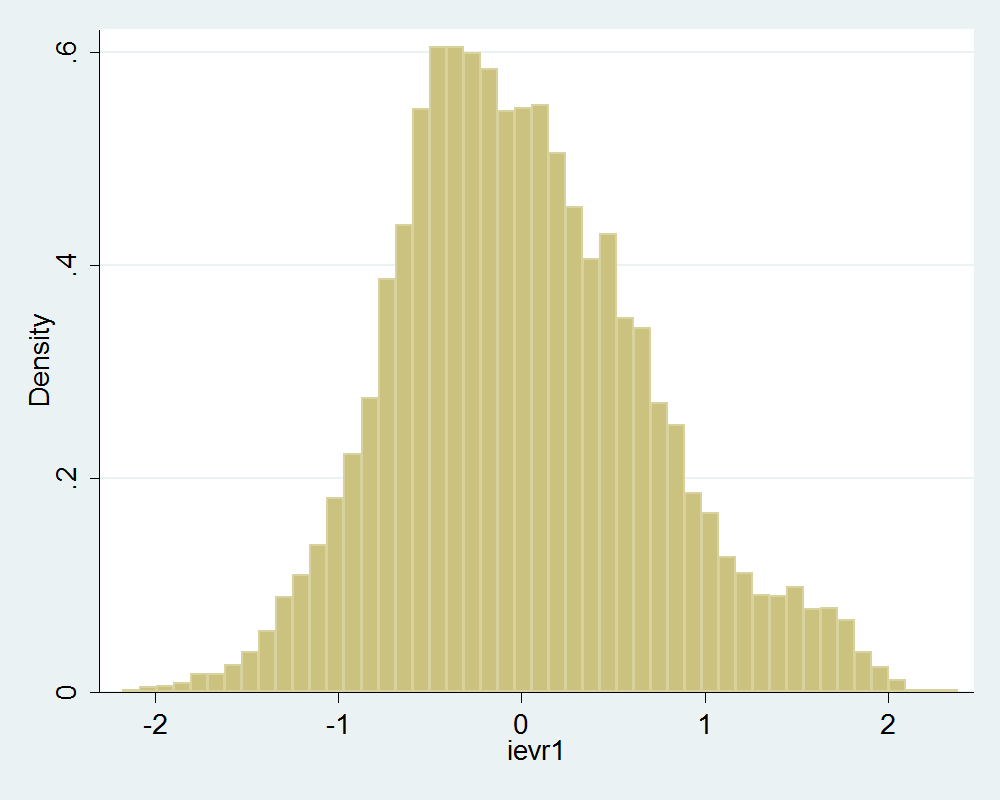

In [17]:
%%stata -s nh1 -gr
hist ievr1


(bin=49, start=-3.3846417, width=.11300206)


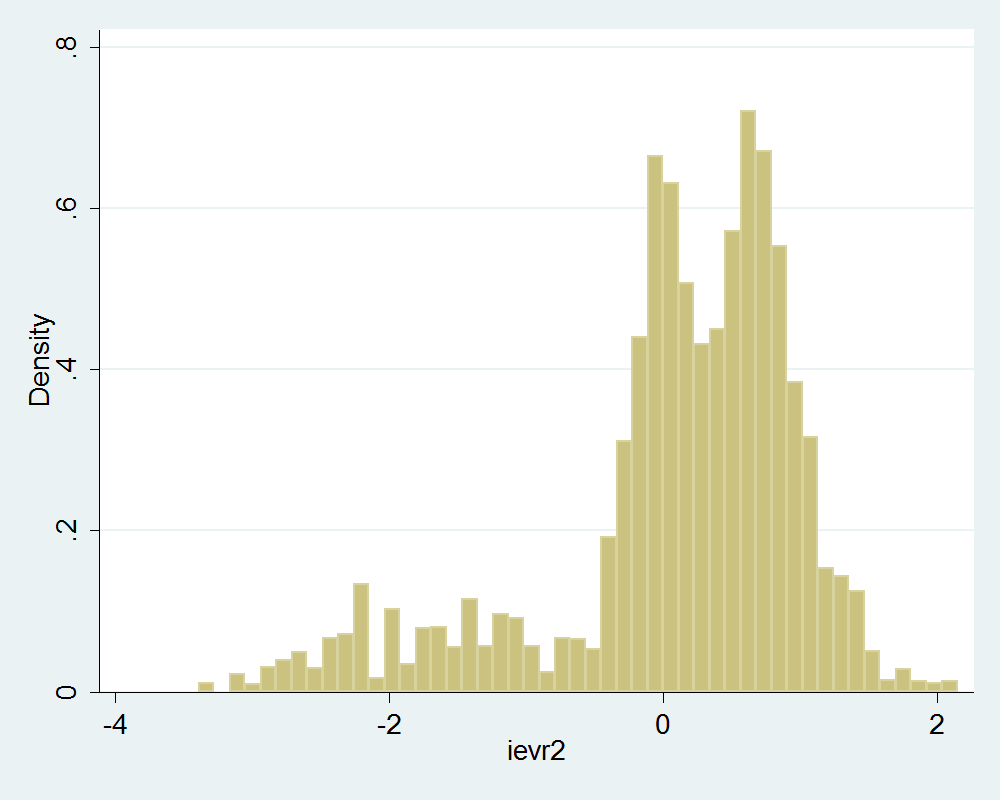

In [18]:
%%stata -s nh1 -gr
hist ievr2


(bin=35, start=-1.6450304, width=.08211953)


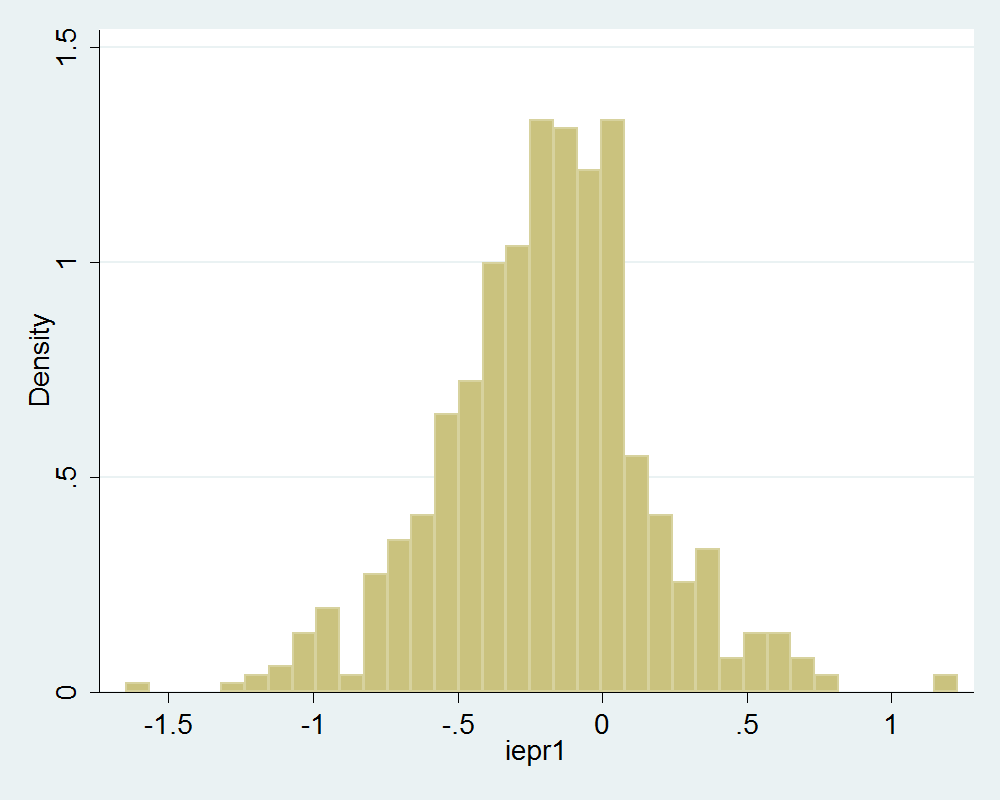

In [19]:
%%stata -s nh1 -gr
hist iepr1


(bin=35, start=-.78343923, width=.04104027)


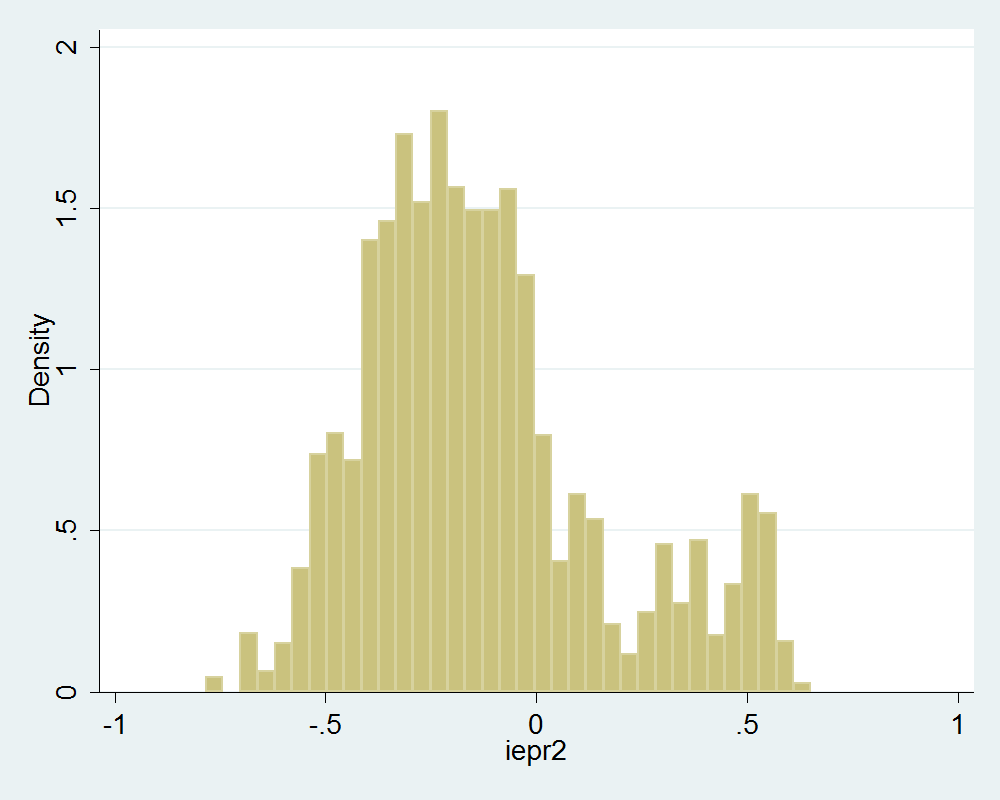

In [20]:
%%stata -s nh1 -gr
hist iepr2

## An aside - does anyone ever model random effects with a mixture distribution? Maybe that would be a neat paper...